In [ ]:
cd ATML-PA-2/

/kaggle/working/ATML-PA-2/IRM


In [22]:
import importlib
import torch
import utils
import architecture
import train
import types
importlib.reload(utils)
importlib.reload(architecture)
importlib.reload(train)


from utils.dataset import FeatureTensorDataset, OfficeHomeDataset, _truncate_resnet_from
from torchvision.models import ResNet50_Weights 
from importlib import reload
import train
from train import train_workflow
import types
from utils.tsne import tsne_plot, get_features
from utils.evaluation import evaluate_ds
import matplotlib.pyplot as plt
import os
from architecture import resnet_classifier
import torch

In [23]:
root_dir = "../datasets/OfficeHomeDataset"
csv_file = f"{root_dir}/ImageInfo.csv"

transform = ResNet50_Weights.IMAGENET1K_V1.transforms()
classes = os.listdir(f"{root_dir}/Art")

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
def make_cache(domains, layer_name):
    model = resnet_classifier(len(classes))
    if len(domains)>1:
        caches = []
        for domain in domains:
            ds = OfficeHomeDataset(root_dir, csv_file, [domain], transform)
            caches.append(FeatureTensorDataset(ds, model, layer_name, device=device, batch_size=64))
        return caches
    else:
        ds = OfficeHomeDataset(root_dir, csv_file, domains, transform)
        return FeatureTensorDataset(ds, model, layer_name, device=device, batch_size=64)


In [ ]:
def analysis(sources, target, config, caches_source=None, cache_target=None):
    
    if caches_source is None:
        caches_source = make_cache(sources, 'layer3')
        

    if cache_target is None:
        cache_target = make_cache(target, 'layer3')

    model = resnet_classifier(num_classes=len(classes))
    truncated_model = _truncate_resnet_from(model, 'layer3')
    # model.layer3.grad=False

    def _forward_impl(self, x):
        f4 = self.layer4(x)
        x = torch.flatten(self.avgpool(f4), 1)
        x = self.fc(x)
        return x

    import types
    truncated_model.forward = types.MethodType(_forward_impl, truncated_model)

    print("Evaluating on target domain test set")
    
    
    train_workflow(truncated_model, caches_source, cache_target, config, device)
    evaluate_ds(cache_target, truncated_model, device, target[0], None)


In [8]:
sources = ["Art", "Real World", "Product"]
target = ["Clipart"]

caches_source = make_cache(sources, 'layer3')
cache_target = make_cache(target, 'layer3')

Precomputing up to layer3: 100%|██████████| 69/69 [00:46<00:00,  1.48it/s]


Evaluating on target domain test set


Training:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1/50


Training:   2%|▏         | 1/50 [00:16<13:34, 16.62s/it]

	ERM loss: 10.897760	Grad penalty: 0.129480	Train Accuracy: 30.59	Test Accuracy: 17.82

Epoch 2/50


Training:   4%|▍         | 2/50 [00:33<13:13, 16.52s/it]

	ERM loss: 8.625384	Grad penalty: 0.273444	Train Accuracy: 40.10	Test Accuracy: 23.09

Epoch 3/50


Training:   6%|▌         | 3/50 [00:49<12:58, 16.55s/it]

	ERM loss: 6.792338	Grad penalty: 0.213838	Train Accuracy: 52.24	Test Accuracy: 28.16

Epoch 4/50


Training:   8%|▊         | 4/50 [01:06<12:42, 16.57s/it]

	ERM loss: 5.344297	Grad penalty: 0.213686	Train Accuracy: 62.10	Test Accuracy: 33.31

Epoch 5/50


Training:  10%|█         | 5/50 [01:22<12:21, 16.48s/it]

	ERM loss: 4.383099	Grad penalty: 0.147375	Train Accuracy: 69.72	Test Accuracy: 37.23

Epoch 6/50


Training:  12%|█▏        | 6/50 [01:39<12:06, 16.52s/it]

	ERM loss: 3.720728	Grad penalty: 0.129872	Train Accuracy: 74.35	Test Accuracy: 40.69

Epoch 7/50


Training:  14%|█▍        | 7/50 [01:55<11:49, 16.49s/it]

	ERM loss: 3.087052	Grad penalty: 0.121152	Train Accuracy: 77.89	Test Accuracy: 42.70

Epoch 8/50


Training:  16%|█▌        | 8/50 [02:11<11:30, 16.44s/it]

	ERM loss: 2.693351	Grad penalty: 0.099943	Train Accuracy: 79.96	Test Accuracy: 43.46

Epoch 9/50


Training:  18%|█▊        | 9/50 [02:28<11:14, 16.45s/it]

	ERM loss: 2.409902	Grad penalty: 0.049670	Train Accuracy: 81.67	Test Accuracy: 43.94

Epoch 10/50


Training:  20%|██        | 10/50 [02:44<10:59, 16.48s/it]

	ERM loss: 2.173186	Grad penalty: 0.047350	Train Accuracy: 83.63	Test Accuracy: 45.29

Epoch 11/50


Training:  22%|██▏       | 11/50 [03:01<10:43, 16.49s/it]

	ERM loss: 1.987899	Grad penalty: 0.047694	Train Accuracy: 85.03	Test Accuracy: 45.06

Epoch 12/50


Training:  24%|██▍       | 12/50 [03:17<10:26, 16.48s/it]

	ERM loss: 1.813285	Grad penalty: 0.050595	Train Accuracy: 86.06	Test Accuracy: 46.44

Epoch 13/50


Training:  26%|██▌       | 13/50 [03:34<10:09, 16.49s/it]

	ERM loss: 1.670413	Grad penalty: 0.036386	Train Accuracy: 87.35	Test Accuracy: 45.80

Epoch 14/50


Training:  28%|██▊       | 14/50 [03:50<09:52, 16.45s/it]

	ERM loss: 1.543782	Grad penalty: 0.034173	Train Accuracy: 88.48	Test Accuracy: 45.34

Epoch 15/50


Training:  30%|███       | 15/50 [04:07<09:37, 16.50s/it]

	ERM loss: 1.437123	Grad penalty: 0.018212	Train Accuracy: 88.84	Test Accuracy: 46.55

Epoch 16/50


Training:  32%|███▏      | 16/50 [04:24<09:22, 16.54s/it]

	ERM loss: 1.302770	Grad penalty: 0.029707	Train Accuracy: 90.09	Test Accuracy: 45.54

Epoch 17/50


Training:  34%|███▍      | 17/50 [04:40<09:08, 16.63s/it]

	ERM loss: 1.243405	Grad penalty: 0.023844	Train Accuracy: 90.81	Test Accuracy: 46.44

Epoch 18/50


Training:  36%|███▌      | 18/50 [04:57<08:49, 16.55s/it]

	ERM loss: 1.179913	Grad penalty: 0.023186	Train Accuracy: 91.60	Test Accuracy: 46.30

Epoch 19/50


Training:  38%|███▊      | 19/50 [05:13<08:33, 16.57s/it]

	ERM loss: 1.070876	Grad penalty: 0.019835	Train Accuracy: 92.20	Test Accuracy: 46.99

Epoch 20/50


Training:  40%|████      | 20/50 [05:30<08:16, 16.56s/it]

	ERM loss: 1.002208	Grad penalty: 0.021270	Train Accuracy: 92.91	Test Accuracy: 47.01

Epoch 21/50


Training:  42%|████▏     | 21/50 [05:46<07:58, 16.49s/it]

	ERM loss: 0.937449	Grad penalty: 0.015662	Train Accuracy: 93.38	Test Accuracy: 47.42

Epoch 22/50


Training:  44%|████▍     | 22/50 [06:03<07:41, 16.47s/it]

	ERM loss: 0.864124	Grad penalty: 0.027169	Train Accuracy: 94.09	Test Accuracy: 46.94

Epoch 23/50


Training:  46%|████▌     | 23/50 [06:19<07:24, 16.47s/it]

	ERM loss: 0.852425	Grad penalty: -0.000022	Train Accuracy: 94.52	Test Accuracy: 47.42

Epoch 24/50


Training:  48%|████▊     | 24/50 [06:36<07:08, 16.48s/it]

	ERM loss: 0.779691	Grad penalty: 0.015689	Train Accuracy: 95.04	Test Accuracy: 46.74

Epoch 25/50


Training:  50%|█████     | 25/50 [06:52<06:51, 16.46s/it]

	ERM loss: 0.717564	Grad penalty: 0.020446	Train Accuracy: 95.50	Test Accuracy: 46.53

Epoch 26/50


Training:  52%|█████▏    | 26/50 [07:09<06:37, 16.57s/it]

	ERM loss: 0.667022	Grad penalty: 0.034566	Train Accuracy: 95.66	Test Accuracy: 47.01

Epoch 27/50


Training:  54%|█████▍    | 27/50 [07:25<06:20, 16.56s/it]

	ERM loss: 0.628887	Grad penalty: 0.031515	Train Accuracy: 96.13	Test Accuracy: 47.01

Epoch 28/50


Training:  56%|█████▌    | 28/50 [07:42<06:04, 16.56s/it]

	ERM loss: 0.583163	Grad penalty: 0.014993	Train Accuracy: 96.34	Test Accuracy: 46.48

Epoch 29/50


Training:  58%|█████▊    | 29/50 [07:59<05:49, 16.63s/it]

	ERM loss: 0.567367	Grad penalty: 0.004394	Train Accuracy: 96.79	Test Accuracy: 46.32

Epoch 30/50


Training:  60%|██████    | 30/50 [08:15<05:31, 16.59s/it]

	ERM loss: 0.520193	Grad penalty: 0.019405	Train Accuracy: 96.84	Test Accuracy: 46.60

Epoch 31/50


Training:  62%|██████▏   | 31/50 [08:32<05:15, 16.60s/it]

	ERM loss: 0.492394	Grad penalty: 0.005096	Train Accuracy: 97.24	Test Accuracy: 46.12

Epoch 32/50


Training:  64%|██████▍   | 32/50 [08:48<04:57, 16.55s/it]

	ERM loss: 0.468515	Grad penalty: 0.018151	Train Accuracy: 97.36	Test Accuracy: 47.03

Epoch 33/50


Training:  66%|██████▌   | 33/50 [09:05<04:41, 16.57s/it]

	ERM loss: 0.430670	Grad penalty: 0.007514	Train Accuracy: 97.52	Test Accuracy: 46.62

Epoch 34/50


Training:  68%|██████▊   | 34/50 [09:21<04:24, 16.54s/it]

	ERM loss: 0.424956	Grad penalty: 0.014305	Train Accuracy: 97.75	Test Accuracy: 46.67

Epoch 35/50


Training:  70%|███████   | 35/50 [09:38<04:08, 16.57s/it]

	ERM loss: 0.372858	Grad penalty: 0.010981	Train Accuracy: 97.86	Test Accuracy: 45.64

Epoch 36/50


Training:  72%|███████▏  | 36/50 [09:54<03:51, 16.50s/it]

	ERM loss: 0.386949	Grad penalty: 0.028273	Train Accuracy: 98.09	Test Accuracy: 46.69

Epoch 37/50


Training:  74%|███████▍  | 37/50 [10:11<03:34, 16.53s/it]

	ERM loss: 0.342215	Grad penalty: -0.003212	Train Accuracy: 98.21	Test Accuracy: 45.68

Epoch 38/50


Training:  76%|███████▌  | 38/50 [10:27<03:18, 16.52s/it]

	ERM loss: 0.343405	Grad penalty: 0.013335	Train Accuracy: 98.37	Test Accuracy: 46.23

Epoch 39/50


Training:  78%|███████▊  | 39/50 [10:44<03:02, 16.59s/it]

	ERM loss: 0.308568	Grad penalty: 0.010001	Train Accuracy: 98.44	Test Accuracy: 45.91

Epoch 40/50


Training:  80%|████████  | 40/50 [11:01<02:45, 16.55s/it]

	ERM loss: 0.297415	Grad penalty: 0.032146	Train Accuracy: 98.48	Test Accuracy: 46.74

Epoch 41/50


Training:  82%|████████▏ | 41/50 [11:17<02:28, 16.54s/it]

	ERM loss: 0.278554	Grad penalty: 0.023945	Train Accuracy: 98.57	Test Accuracy: 45.77

Epoch 42/50


Training:  84%|████████▍ | 42/50 [11:34<02:12, 16.58s/it]

	ERM loss: 0.259781	Grad penalty: 0.019970	Train Accuracy: 98.73	Test Accuracy: 45.64

Epoch 43/50


Training:  86%|████████▌ | 43/50 [11:50<01:55, 16.53s/it]

	ERM loss: 0.255046	Grad penalty: -0.004688	Train Accuracy: 98.78	Test Accuracy: 46.07

Epoch 44/50


Training:  88%|████████▊ | 44/50 [12:07<01:38, 16.50s/it]

	ERM loss: 0.240542	Grad penalty: 0.014022	Train Accuracy: 98.87	Test Accuracy: 45.68

Epoch 45/50


Training:  90%|█████████ | 45/50 [12:23<01:22, 16.46s/it]

	ERM loss: 0.217079	Grad penalty: 0.007966	Train Accuracy: 98.91	Test Accuracy: 46.05

Epoch 46/50


Training:  92%|█████████▏| 46/50 [12:40<01:05, 16.46s/it]

	ERM loss: 0.220782	Grad penalty: 0.007540	Train Accuracy: 98.97	Test Accuracy: 46.21

Epoch 47/50


Training:  94%|█████████▍| 47/50 [12:56<00:49, 16.49s/it]

	ERM loss: 0.209821	Grad penalty: 0.013162	Train Accuracy: 98.95	Test Accuracy: 46.03

Epoch 48/50


Training:  96%|█████████▌| 48/50 [13:13<00:32, 16.50s/it]

	ERM loss: 0.202057	Grad penalty: 0.009426	Train Accuracy: 99.04	Test Accuracy: 46.16

Epoch 49/50


Training:  98%|█████████▊| 49/50 [13:29<00:16, 16.52s/it]

	ERM loss: 0.201950	Grad penalty: 0.010076	Train Accuracy: 99.09	Test Accuracy: 45.52

Epoch 50/50


Training: 100%|██████████| 50/50 [13:46<00:00, 16.52s/it]

	ERM loss: 0.183833	Grad penalty: 0.023697	Train Accuracy: 99.10	Test Accuracy: 45.59



=== Evaluation for Clipart Domain ===
Accuracy: 45.59%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.5921    0.7500    0.6618        60
           1     0.7333    0.1964    0.3099        56
           2     0.4419    0.2969    0.3551        64
           3     1.0000    0.0714    0.1333        98
           4     0.9512    0.7879    0.8619        99
           5     0.6364    0.2828    0.3916        99
           6     0.4405    0.5068    0.4713        73
           7     0.6000    0.8478    0.7027        46
           8     0.4949    0.6282    0.5537        78
           9     0.6222    0.2828    0.3889        99
          10     0.6588    0.5657    0.6087        99
          11     0.2045    0.2250    0.2143        40
          12     0.3913    0.3636    0.3770        99
          13     0.7000    0.3281    0.4468        64
          14     0.7297    0.6429    0.6835        42
          15     0.1833    0.2683   

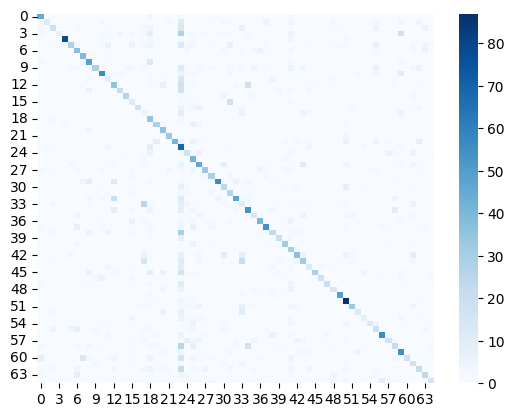

In [34]:
config = {'epochs':50, 
          'lr':4e-3, 
          'batch_size':48,  #larger batchsize 
          'weight_decay':1e-4, 
          'phi':1,
          'scheduling_constant':1.04,
          }
analysis(sources, target, config, caches_source, cache_target)

In [19]:
classes[5]

'Bucket'

Evaluating on target domain test set


Training:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10


Training:  10%|█         | 1/10 [00:16<02:27, 16.44s/it]

	ERM loss: nan	Grad penalty: nan	Train Accuracy: 2.27	Test Accuracy: 1.37

Epoch 2/10


Training:  20%|██        | 2/10 [00:33<02:12, 16.53s/it]

	ERM loss: nan	Grad penalty: nan	Train Accuracy: 2.27	Test Accuracy: 1.37

Epoch 3/10


Training:  30%|███       | 3/10 [00:49<01:55, 16.54s/it]

	ERM loss: nan	Grad penalty: nan	Train Accuracy: 2.27	Test Accuracy: 1.37

Epoch 4/10


Training:  40%|████      | 4/10 [01:06<01:39, 16.53s/it]

	ERM loss: nan	Grad penalty: nan	Train Accuracy: 2.27	Test Accuracy: 1.37

Epoch 5/10


Training:  50%|█████     | 5/10 [01:22<01:22, 16.59s/it]

	ERM loss: nan	Grad penalty: nan	Train Accuracy: 2.27	Test Accuracy: 1.37

Epoch 6/10


Training:  60%|██████    | 6/10 [01:39<01:06, 16.63s/it]

	ERM loss: nan	Grad penalty: nan	Train Accuracy: 2.27	Test Accuracy: 1.37

Epoch 7/10


Training:  70%|███████   | 7/10 [01:55<00:49, 16.59s/it]

	ERM loss: nan	Grad penalty: nan	Train Accuracy: 2.27	Test Accuracy: 1.37

Epoch 8/10


Training:  80%|████████  | 8/10 [02:12<00:33, 16.60s/it]

	ERM loss: nan	Grad penalty: nan	Train Accuracy: 2.27	Test Accuracy: 1.37

Epoch 9/10


Training:  90%|█████████ | 9/10 [02:29<00:16, 16.55s/it]

	ERM loss: nan	Grad penalty: nan	Train Accuracy: 2.27	Test Accuracy: 1.37

Epoch 10/10


Training: 100%|██████████| 10/10 [02:45<00:00, 16.56s/it]

	ERM loss: nan	Grad penalty: nan	Train Accuracy: 2.27	Test Accuracy: 1.37



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



=== Evaluation for Clipart Domain ===
Accuracy: 1.37%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.0137    1.0000    0.0271        60
           1     0.0000    0.0000    0.0000        56
           2     0.0000    0.0000    0.0000        64
           3     0.0000    0.0000    0.0000        98
           4     0.0000    0.0000    0.0000        99
           5     0.0000    0.0000    0.0000        99
           6     0.0000    0.0000    0.0000        73
           7     0.0000    0.0000    0.0000        46
           8     0.0000    0.0000    0.0000        78
           9     0.0000    0.0000    0.0000        99
          10     0.0000    0.0000    0.0000        99
          11     0.0000    0.0000    0.0000        40
          12     0.0000    0.0000    0.0000        99
          13     0.0000    0.0000    0.0000        64
          14     0.0000    0.0000    0.0000        42
          15     0.0000    0.0000    

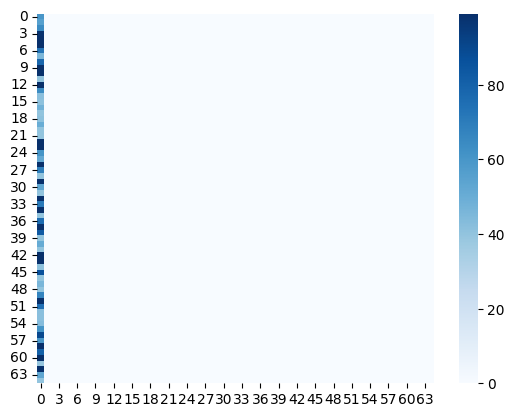

In [38]:
config = {'epochs':10, 
          'lr':4e-3, 
          'batch_size':48,  
          'weight_decay':1e-4, 
          'phi':32,
          'scheduling_constant':1.0,
          }
analysis(sources, target, config, caches_source, cache_target)

Evaluating on target domain test set


Training:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 1/25


Training:   4%|▍         | 1/25 [00:15<06:05, 15.23s/it]

	ERM loss: 11.133415	Grad penalty: 0.096570	Train Accuracy: 28.80	Test Accuracy: 16.38

Epoch 2/25


Training:   8%|▊         | 2/25 [00:30<05:51, 15.27s/it]

	ERM loss: 9.278883	Grad penalty: 0.253201	Train Accuracy: 33.45	Test Accuracy: 18.08

Epoch 3/25


Training:  12%|█▏        | 3/25 [00:46<05:38, 15.36s/it]

	ERM loss: 7.763476	Grad penalty: 0.214918	Train Accuracy: 43.70	Test Accuracy: 24.17

Epoch 4/25


Training:  16%|█▌        | 4/25 [01:01<05:22, 15.36s/it]

	ERM loss: 6.423488	Grad penalty: 0.193617	Train Accuracy: 52.09	Test Accuracy: 28.43

Epoch 5/25


Training:  20%|██        | 5/25 [01:16<05:08, 15.45s/it]

	ERM loss: 5.394032	Grad penalty: 0.169510	Train Accuracy: 58.58	Test Accuracy: 31.23

Epoch 6/25


Training:  24%|██▍       | 6/25 [01:32<04:54, 15.50s/it]

	ERM loss: 4.652635	Grad penalty: 0.116252	Train Accuracy: 65.88	Test Accuracy: 35.62

Epoch 7/25


Training:  28%|██▊       | 7/25 [01:48<04:39, 15.54s/it]

	ERM loss: 4.001991	Grad penalty: 0.136439	Train Accuracy: 69.66	Test Accuracy: 38.44

Epoch 8/25


Training:  32%|███▏      | 8/25 [02:04<04:25, 15.63s/it]

	ERM loss: 3.496977	Grad penalty: 0.103800	Train Accuracy: 74.44	Test Accuracy: 40.99

Epoch 9/25


Training:  36%|███▌      | 9/25 [02:19<04:09, 15.61s/it]

	ERM loss: 3.057238	Grad penalty: 0.102022	Train Accuracy: 77.12	Test Accuracy: 42.50

Epoch 10/25


Training:  40%|████      | 10/25 [02:34<03:52, 15.49s/it]

	ERM loss: 2.814695	Grad penalty: 0.091599	Train Accuracy: 78.50	Test Accuracy: 43.16

Epoch 11/25


Training:  44%|████▍     | 11/25 [02:50<03:36, 15.46s/it]

	ERM loss: 2.537086	Grad penalty: 0.084766	Train Accuracy: 80.37	Test Accuracy: 43.69

Epoch 12/25


Training:  48%|████▊     | 12/25 [03:05<03:21, 15.51s/it]

	ERM loss: 2.310898	Grad penalty: 0.067355	Train Accuracy: 81.77	Test Accuracy: 44.81

Epoch 13/25


Training:  52%|█████▏    | 13/25 [03:21<03:05, 15.48s/it]

	ERM loss: 2.132935	Grad penalty: 0.049012	Train Accuracy: 82.90	Test Accuracy: 45.25

Epoch 14/25


Training:  56%|█████▌    | 14/25 [03:36<02:50, 15.48s/it]

	ERM loss: 1.951176	Grad penalty: 0.040330	Train Accuracy: 83.89	Test Accuracy: 45.84

Epoch 15/25


Training:  60%|██████    | 15/25 [03:52<02:34, 15.47s/it]

	ERM loss: 1.858508	Grad penalty: 0.033356	Train Accuracy: 85.04	Test Accuracy: 46.16

Epoch 16/25


Training:  64%|██████▍   | 16/25 [04:07<02:18, 15.42s/it]

	ERM loss: 1.747298	Grad penalty: 0.013879	Train Accuracy: 85.67	Test Accuracy: 45.54

Epoch 17/25


Training:  68%|██████▊   | 17/25 [04:22<02:03, 15.46s/it]

	ERM loss: 1.654183	Grad penalty: 0.020626	Train Accuracy: 87.02	Test Accuracy: 47.06

Epoch 18/25


Training:  72%|███████▏  | 18/25 [04:38<01:48, 15.45s/it]

	ERM loss: 1.569637	Grad penalty: 0.025763	Train Accuracy: 87.66	Test Accuracy: 46.85

Epoch 19/25


Training:  76%|███████▌  | 19/25 [04:53<01:32, 15.45s/it]

	ERM loss: 1.418317	Grad penalty: 0.049102	Train Accuracy: 88.41	Test Accuracy: 46.37

Epoch 20/25


Training:  80%|████████  | 20/25 [05:09<01:16, 15.39s/it]

	ERM loss: 1.385747	Grad penalty: 0.012464	Train Accuracy: 89.30	Test Accuracy: 46.62

Epoch 21/25


Training:  84%|████████▍ | 21/25 [05:24<01:01, 15.38s/it]

	ERM loss: 1.271727	Grad penalty: -0.009691	Train Accuracy: 90.03	Test Accuracy: 46.35

Epoch 22/25


Training:  88%|████████▊ | 22/25 [05:39<00:46, 15.40s/it]

	ERM loss: 1.237024	Grad penalty: 0.048402	Train Accuracy: 90.65	Test Accuracy: 46.19

Epoch 23/25


Training:  92%|█████████▏| 23/25 [05:55<00:30, 15.39s/it]

	ERM loss: 1.172470	Grad penalty: 0.015355	Train Accuracy: 91.05	Test Accuracy: 46.80

Epoch 24/25


Training:  96%|█████████▌| 24/25 [06:11<00:15, 15.49s/it]

	ERM loss: 1.121388	Grad penalty: 0.015879	Train Accuracy: 91.75	Test Accuracy: 47.29

Epoch 25/25


Training: 100%|██████████| 25/25 [06:26<00:00, 15.46s/it]

	ERM loss: 1.028803	Grad penalty: 0.030276	Train Accuracy: 91.99	Test Accuracy: 47.08



=== Evaluation for Clipart Domain ===
Accuracy: 47.08%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.7049    0.7167    0.7107        60
           1     0.6667    0.2500    0.3636        56
           2     0.4444    0.3750    0.4068        64
           3     0.6667    0.0612    0.1121        98
           4     0.9367    0.7475    0.8315        99
           5     0.4923    0.3232    0.3902        99
           6     0.4342    0.4521    0.4430        73
           7     0.6441    0.8261    0.7238        46
           8     0.4757    0.6282    0.5414        78
           9     0.6200    0.3131    0.4161        99
          10     0.5755    0.6162    0.5951        99
          11     0.0000    0.0000    0.0000        40
          12     0.5094    0.2727    0.3553        99
          13     0.8571    0.1875    0.3077        64
          14     0.8182    0.6429    0.7200        42
          15     0.1757    0.3171   

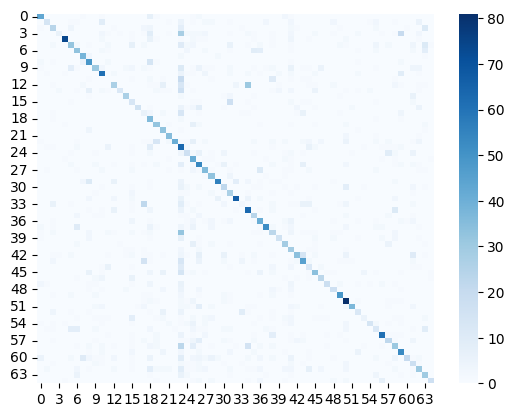

In [45]:
#trained after freezing layer3
config = {'epochs':25, 
          'lr':4e-3, 
          'batch_size':64,  
          'weight_decay':1e-3, 
          'phi':1.0,
          'scheduling_constant':1.05,
          }
analysis(sources, target, config, caches_source, cache_target)